Image: 102.png, GPR: 4.9


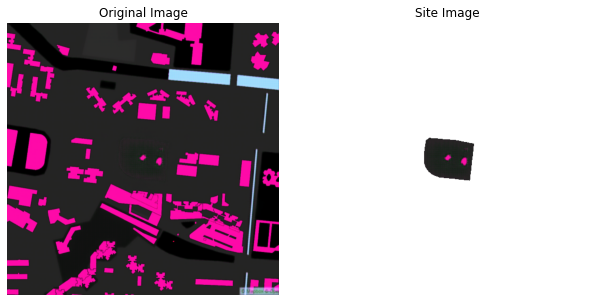

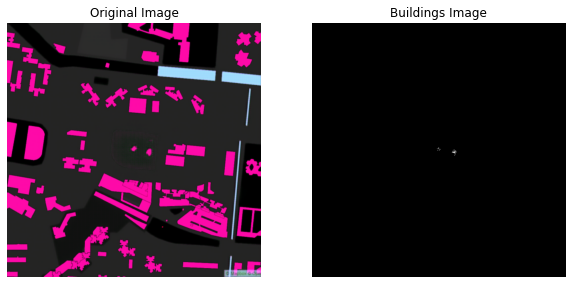

Image: 1071.png, GPR: 2.1


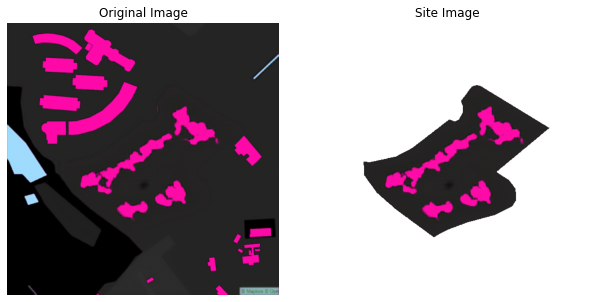

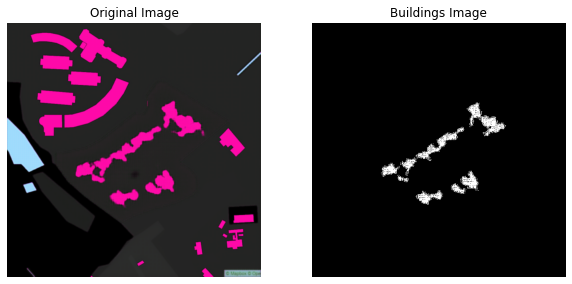

Image: 1074.png, GPR: 2.5


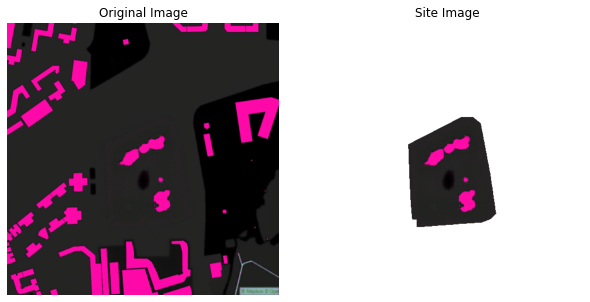

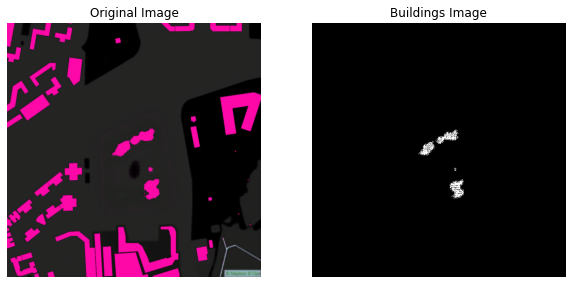

Image: 1075.png, GPR: 1.4


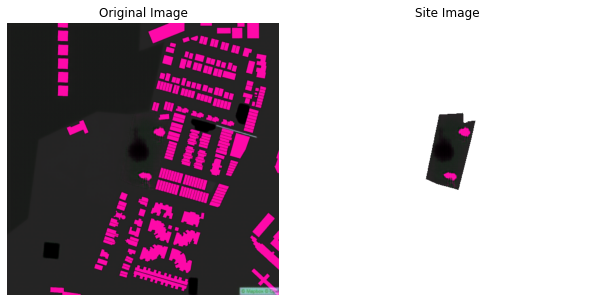

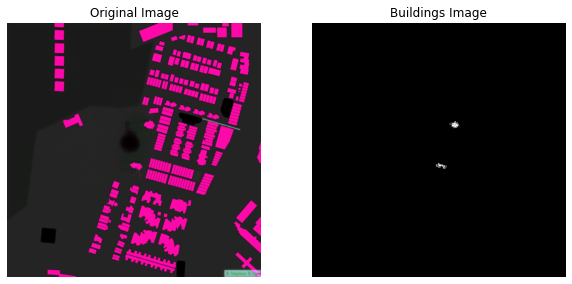

Image: 1131.png, GPR: 2.8


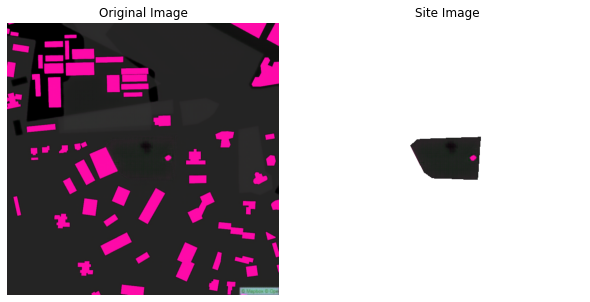

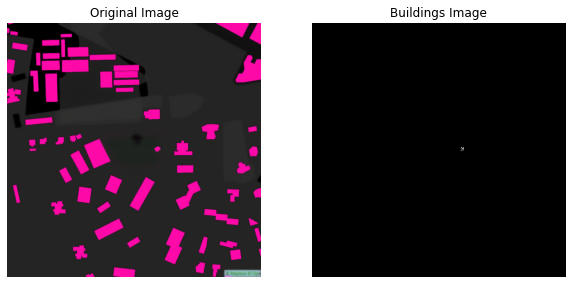

Image: 1271.png, GPR: 2.1


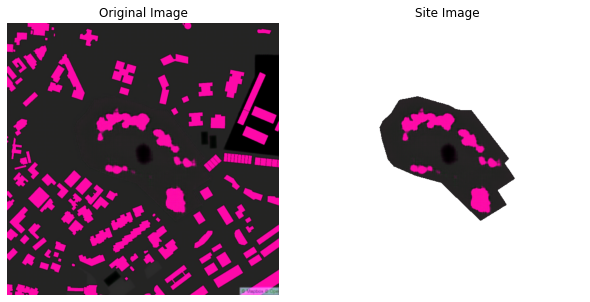

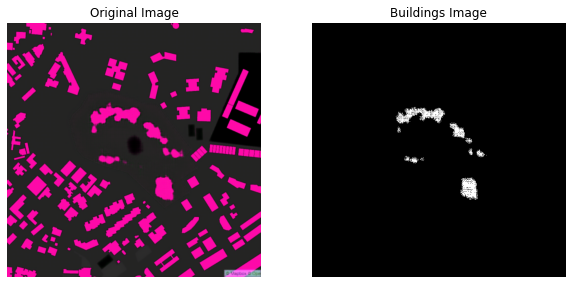

Image: 1297.png, GPR: 2.1


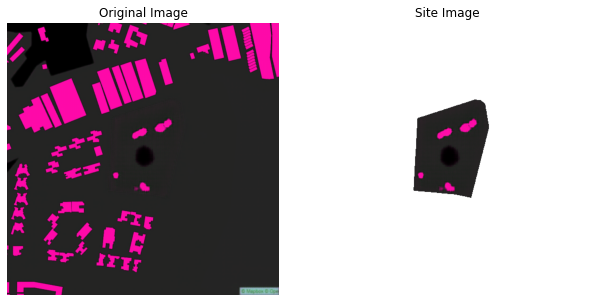

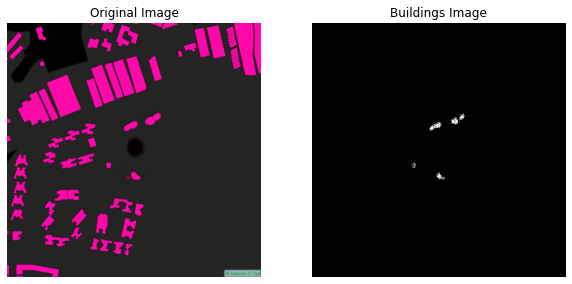

Image: 1306.png, GPR: 3.0


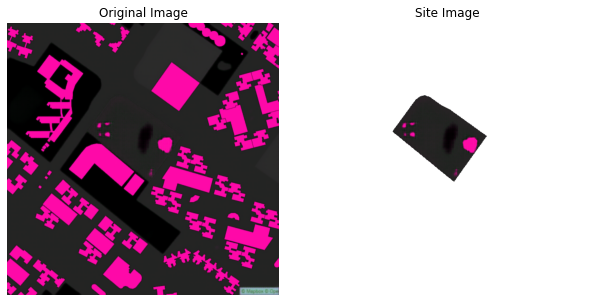

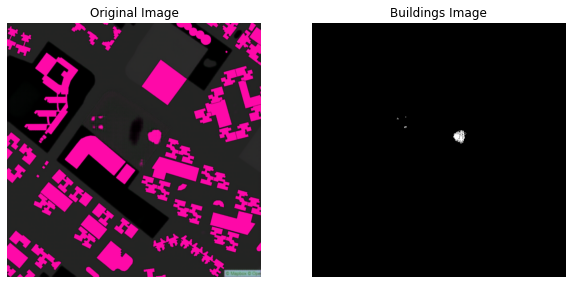

Image: 1308.png, GPR: 3.0


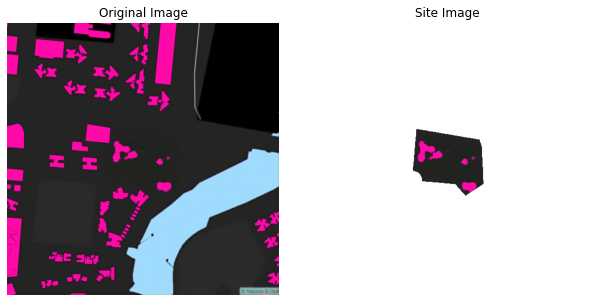

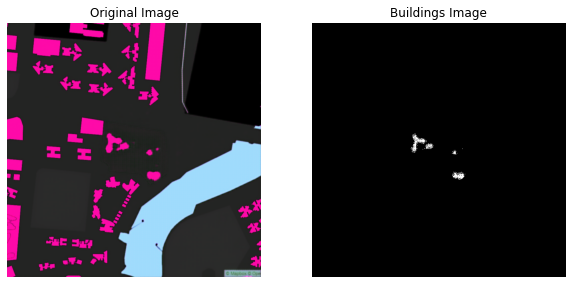

Image: 1588.png, GPR: 1.4


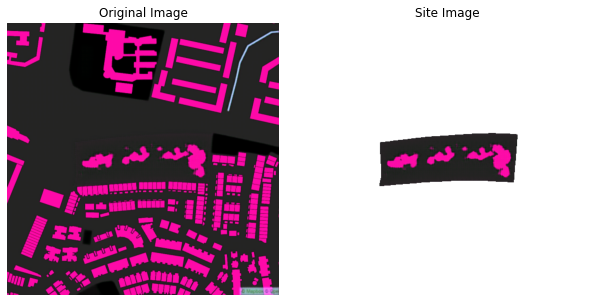

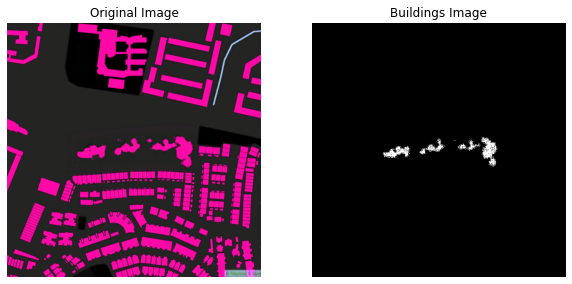

Image: 165.png, GPR: 2.8


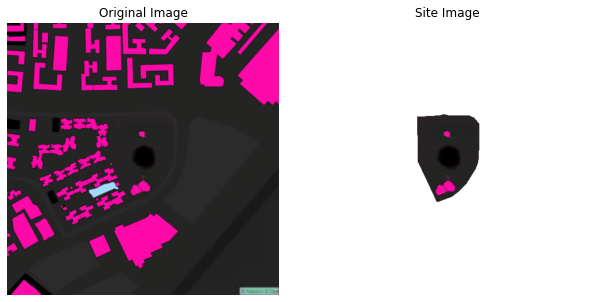

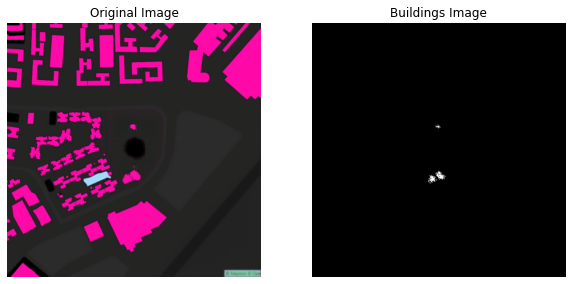

Image: 1699.png, GPR: 2.5


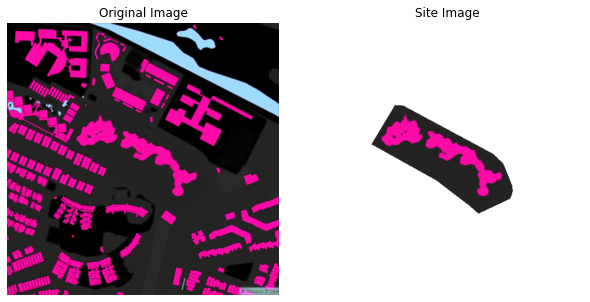

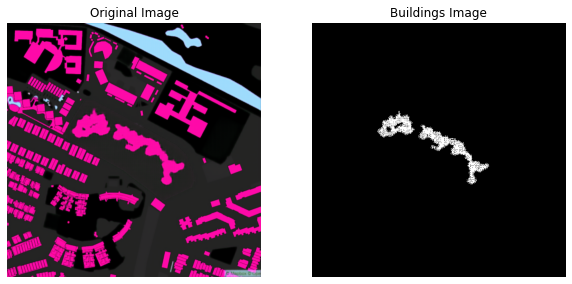

Image: 1761.png, GPR: 1.4


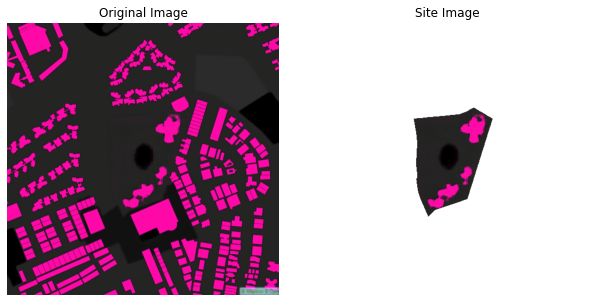

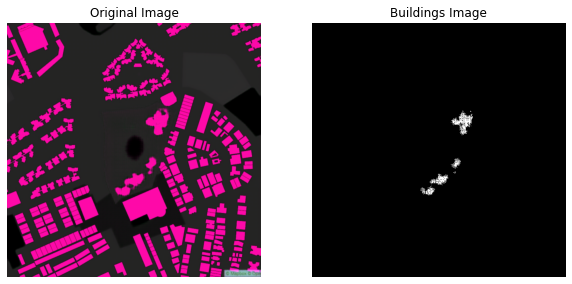

Image: 1786.png, GPR: 1.4


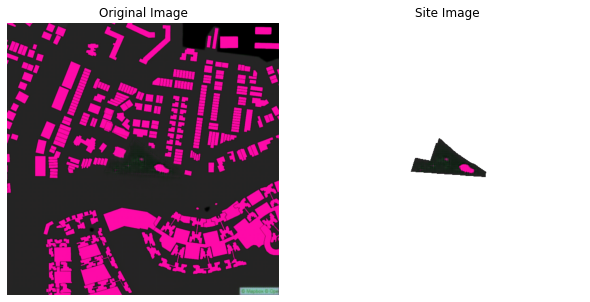

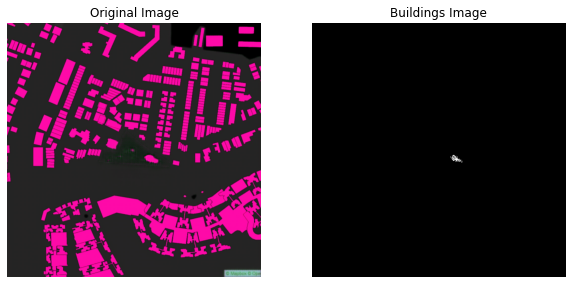

Image: 1838.png, GPR: 2.8


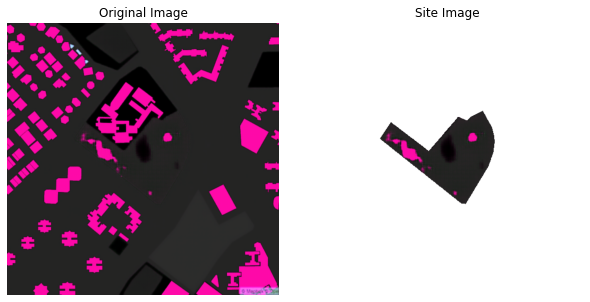

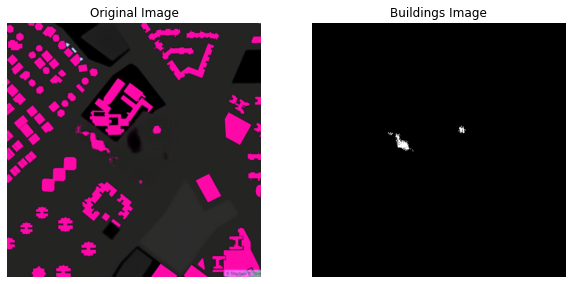

Image: 1922.png, GPR: 1.4


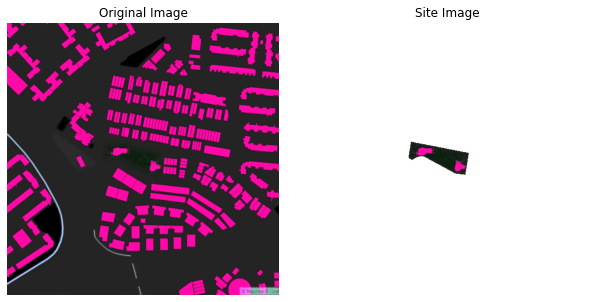

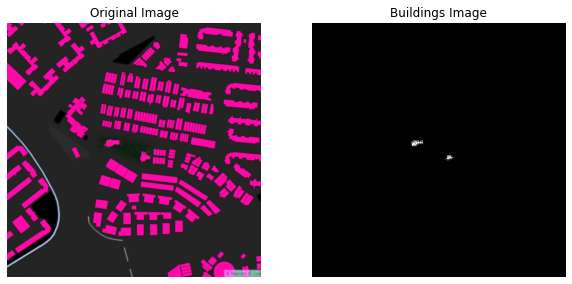

Image: 2007.png, GPR: 2.5


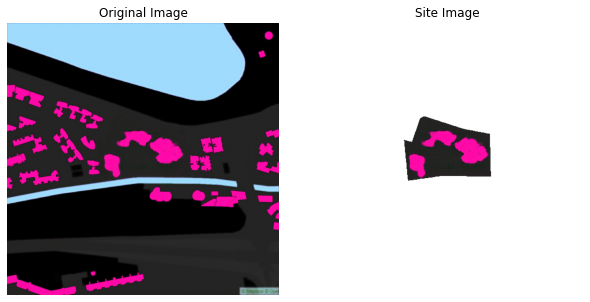

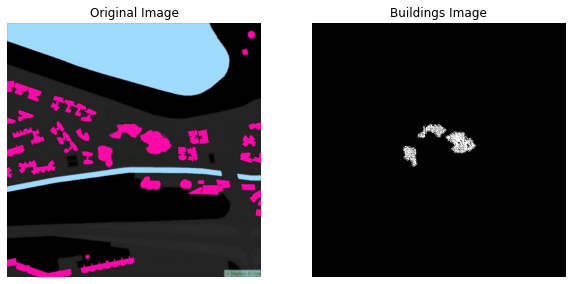

Image: 403.png, GPR: 2.8


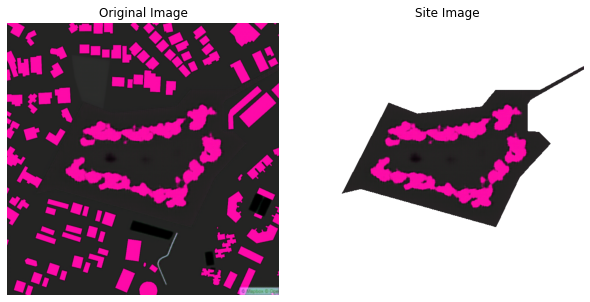

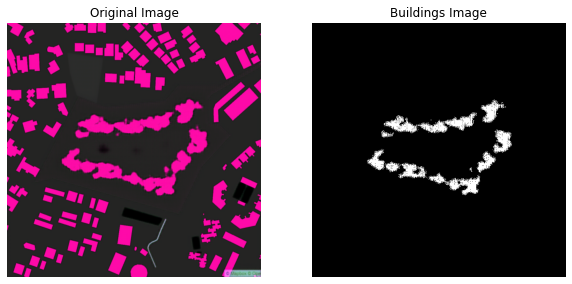

Image: 491.png, GPR: 3.0


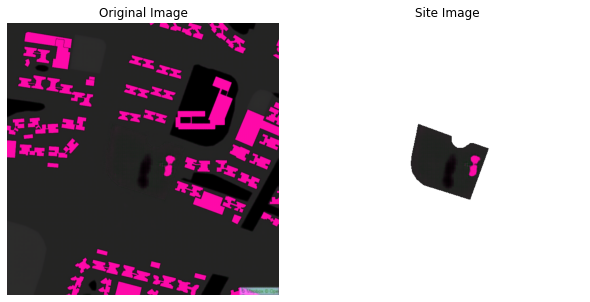

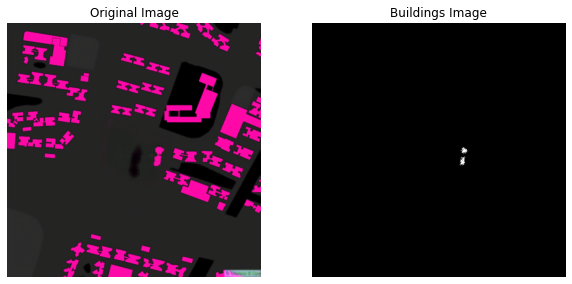

Image: 520.png, GPR: 3.0


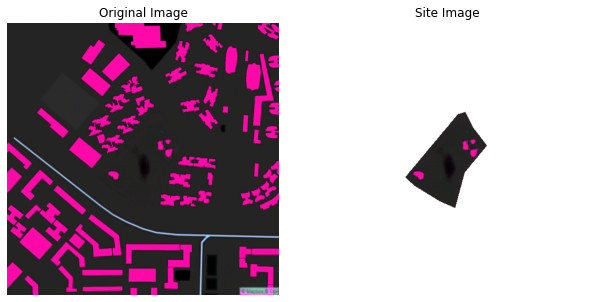

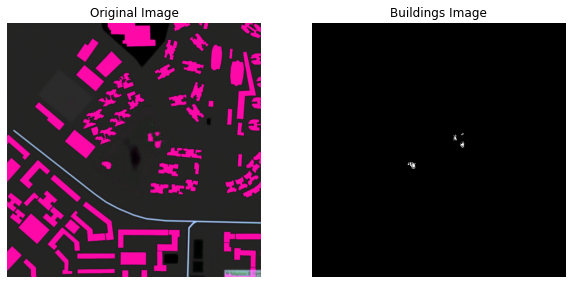

Image: 589.png, GPR: 1.4


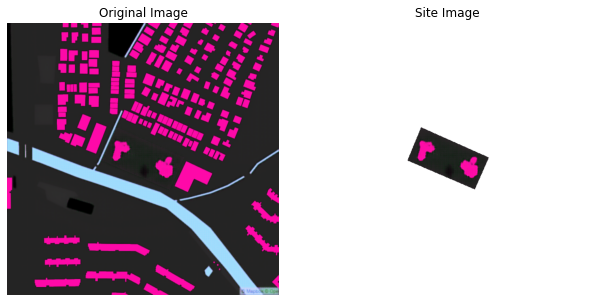

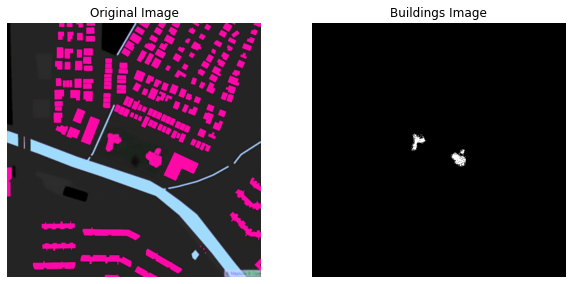

Image: 671.png, GPR: 1.6


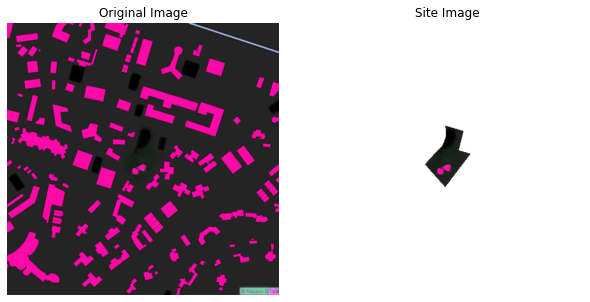

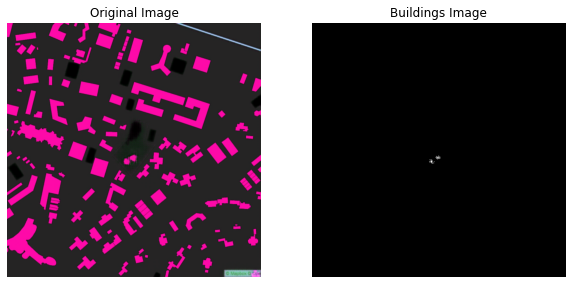

Image: 78.png, GPR: 2.8


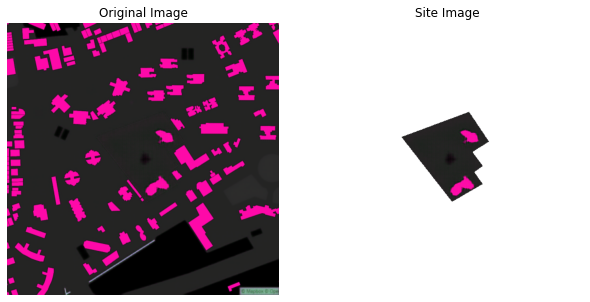

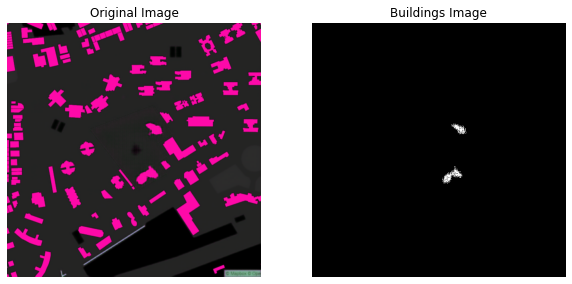

Image: 839.png, GPR: 2.8


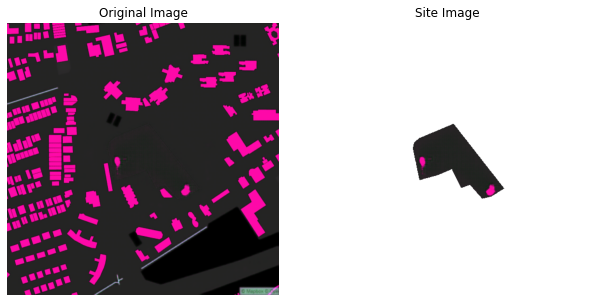

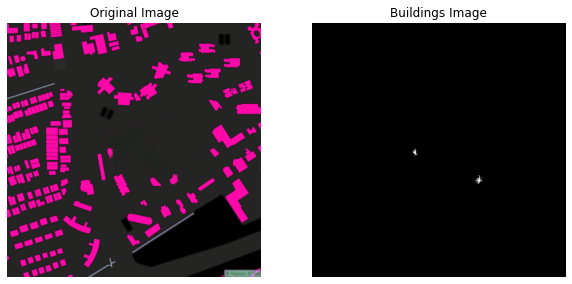

Image: 861.png, GPR: 2.1


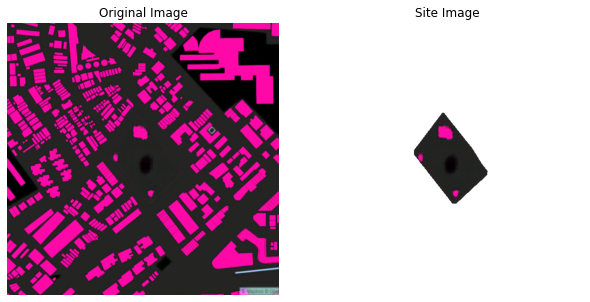

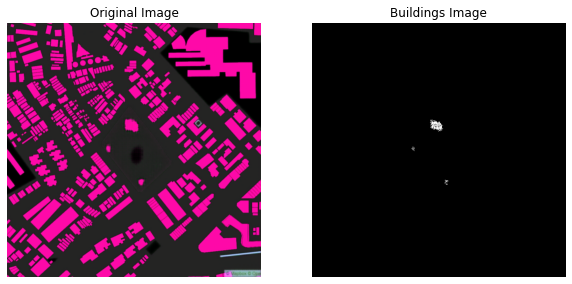

Image: 882.png, GPR: 3.0


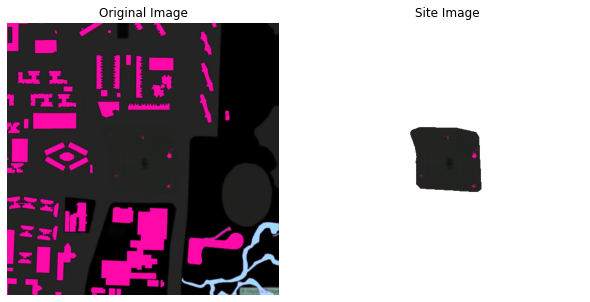

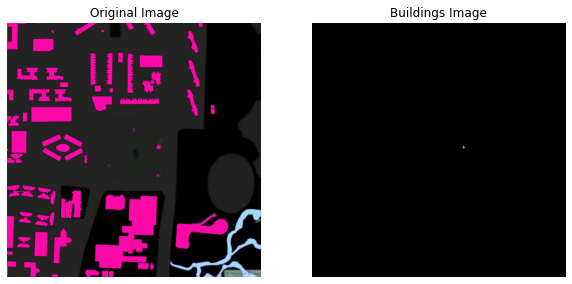

Image: 902.png, GPR: 3.0


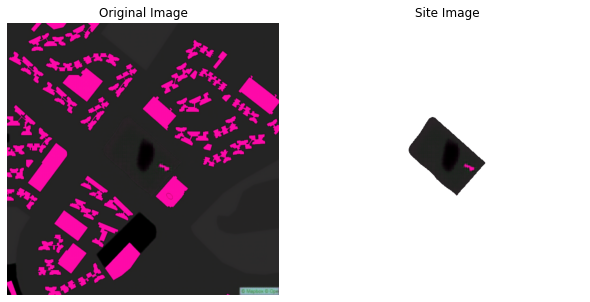

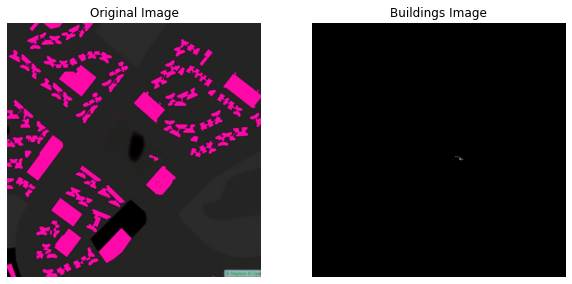

Accuracies [0.9469478775900294, -0.760569612844838, 0.2464994165694283, 0.8167261502845568, 0.9634316508684984, -0.677519535163294, 0.6190851568493585, 0.5930287329251059, 0.10034831647039304, 0.1626593783438833, 0.6697073674226575, -1.6482037469798392, 0.392897490053539, 0.7926696004016657, 0.511840221549438, 0.5305566368236668, -1.4065753424657537, -1.5118321541839472, 0.7708684331444324, 0.7866505951484104, 0.2153896033718794, 0.8183783783783785, 0.25317796610169485, 0.827588254152962, 0.5371620848307276, 0.9876707530647986, 0.9732912918482798]
Images ['102.png', '1071.png', '1074.png', '1075.png', '1131.png', '1271.png', '1297.png', '1306.png', '1308.png', '1588.png', '165.png', '1699.png', '1761.png', '1786.png', '1838.png', '1922.png', '2007.png', '403.png', '491.png', '520.png', '589.png', '671.png', '78.png', '839.png', '861.png', '882.png', '902.png']


In [1]:
from PIL import Image, ImageEnhance
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import pandas as pd

import requests
import json
import re
import csv

directory_path = os.getcwd()

csv_path = os.path.join(directory_path, 'pix2pix_models\\site_area.csv')
masked_image_path = os.path.join(directory_path, 'pix2pix_models\\data\\mapbox_clear_data\\input\\')
generated_image_path = os.path.join(directory_path, 'pix2pix_models\\outputs\\clear_output\\') 

# Read the CSV file
data = pd.read_csv(csv_path)

# Function to extract the numeric part of the filename
def extract_numeric_part(filename):
    numeric_part = ''.join(filter(str.isdigit, filename))
    return int(numeric_part) if numeric_part else None

def create_binary_mask(arr, target_color, threshold=30):
    lower_bound = np.array(target_color) - threshold
    upper_bound = np.array(target_color) + threshold
    mask = (arr[:, :, :3] >= lower_bound) & (arr[:, :, :3] <= upper_bound)
    return np.all(mask, axis=-1)

def extract_building_regions(arr, target_color, threshold=10):
    lower_bound = np.array(target_color) - threshold
    upper_bound = np.array(target_color) + threshold
    mask = (arr[:, :, :3] >= lower_bound) & (arr[:, :, :3] <= upper_bound)
    return np.all(mask, axis=-1)

def find_max_building_storeys(gpr):
    max_building_storeys= 0
    if gpr >= 0 and gpr < 1.4:
        max_building_storeys = 5
    elif gpr >= 1.4 and gpr < 1.6:
        max_building_storeys = 12
    elif gpr >= 1.6 and gpr < 2.1:
        max_building_storeys = 24
    elif gpr >= 2.1 and gpr < 2.8:
        max_building_storeys = 36
    elif gpr >= 2.8:
        max_building_storeys = 48 ## by right got no limit
    return max_building_storeys


accuracies = []
images = []
ok_image_list = ['102.png', '1071.png', '1074.png', '1075.png', '1131.png', '1271.png', '1297.png', '1306.png', '1308.png', '1588.png', '165.png', '1699.png', '1761.png', '1786.png', '1838.png', '1922.png', '2007.png', '403.png', '491.png', '520.png', '589.png', '671.png', '78.png', '839.png', '861.png', '882.png', '902.png']

# Iterate through the images in the generated_image_path
for image_file in ok_image_list:
    if image_file.endswith('.png'):
        image_index = extract_numeric_part(image_file)

        # Construct the path for the corresponding masked image
        mask_image_filename = f"{image_index}.png"
        mask_image = os.path.join(masked_image_path, mask_image_filename)
        generated_image = os.path.join(generated_image_path, image_file)

        # Check if the image index matches any index in the CSV
        matched_row = data[data['Index'] == image_index]
        if not matched_row.empty:
            # Extract the GPR value for the matched row
            gpr_value = matched_row['GPR'].iloc[0]
            actual_site_area = matched_row['Area'].iloc[0]
            actual_site_area = actual_site_area.replace(',', '')
            actual_site_area = float(actual_site_area[:-4])
            gpr_value = float(gpr_value)
            

            print(f'Image: {image_file}, GPR: {gpr_value}')
            mask_image = Image.open(mask_image)  # 512x512
            generated_image =  Image.open(generated_image)
            mask_array = np.array(mask_image)
            generated_array = np.array(generated_image)
            mask_color = [255, 255, 0]  # bright yellow
            site_mask = create_binary_mask(mask_array, mask_color)
            site_area_array = generated_array.copy()
            site_area_array[~site_mask] = [255, 255, 255, 255] # making non-masked region white RMB ITS 4 CHANNELS NOW
            site_area_image = Image.fromarray(site_area_array)
            
            plt.figure(figsize=(20, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(generated_image)
            plt.title('Original Image')
            plt.axis('off')
            plt.subplot(1, 3, 2)
            plt.imshow(site_area_image)
            plt.title('Site Image')
            plt.axis('off')
            plt.show()

            mask_color = [250, 8, 162]  # bright pink
            building_mask = extract_building_regions(site_area_array, mask_color)
            buildings_image = Image.fromarray(building_mask)

            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(generated_image)
            plt.title('Original Image')
            plt.axis('off')
            plt.subplot(1, 2, 2)
            plt.imshow(buildings_image, cmap='gray')
            plt.title('Buildings Image')
            plt.axis('off')
            plt.show()

            # find site:building area ratio
            building_pixels = np.sum(building_mask)
            mask_pixels = np.sum(site_mask)
            ratio = float(building_pixels / mask_pixels)

            # accuracy
            building_area = ratio * actual_site_area
            max_storeys = find_max_building_storeys(gpr_value)
            generated_gpr = building_area*max_storeys/actual_site_area
            accuracy = (gpr_value - generated_gpr) / gpr_value #gpr_value is the target gpr
            images.append(image_file)
            accuracies.append(accuracy)

print('Accuracies', accuracies)
print('Images', images)
##TODO##
#summation/len(deviations)


In [3]:
total_data = len(accuracies)
model_accuracy = sum(accuracies)/total_data
print("clear_output(pink)",model_accuracy)

clear_output(pink) 0.27821759127985596
